In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [7]:
train = pd.read_csv('train_498AML.csv', header = None)

In [8]:
train = train.rename(columns = {0:'Age', 1:'workclass', 2:'fnlwgt', 3:'Education', 4:'education-num', 5:'marital-status',
                               6:'occupation', 7:'relationship', 8:'race', 9:'sex', 10:'capital-gain', 11:'capital-loss',
                               12:'hours-per-week', 13:'native-country', 14:'Class'})

In [9]:
features = ['Age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X = train[features]
X = X.values

In [10]:
Y = train['Class']
Y = Y.values
Y[Y == ' <=50K'] = -1
Y[Y == ' >50K'] = 1
Y = np.array(Y).astype(int)

In [11]:
print(X.shape)
print(Y.shape)

(43957, 6)
(43957,)


In [12]:
def train_valid_test_split(X, Y, perc_train, perc_valid, perc_test):
    
    N = len(Y)
    train_size = int((N) * perc_train)
    valid_size = int((N) * perc_valid) + train_size
    shuffled_idx = np.random.permutation(N)
    
    train_idx = shuffled_idx[:train_size]
    valid_idx = shuffled_idx[train_size:valid_size]
    test_idx = shuffled_idx[valid_size:]
    
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    
    X_valid = X[valid_idx]
    Y_valid = Y[valid_idx]
    
    X_test = X[test_idx]
    Y_test = Y[test_idx]
    
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [13]:
perc_train = 0.7
perc_valid = 0.2
perc_test = 0.1

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(X, Y, perc_train, perc_valid, perc_test)

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(30769, 6)
(30769,)
(8791, 6)
(8791,)
(4397, 6)
(4397,)


In [15]:
def scaled_data(X):
    
    m = X.mean(axis = 0)
    s = X.std(axis = 0)
    
    u = (X - m) / s
    
    return u

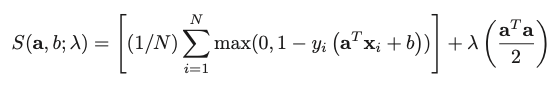

In [16]:
def gradient(X, Y, a, b):
    
    """
    c = 1 - y * ((a.T * x) + b)
    
    X = N * D
    Y = N * 1
    a = 1 * D
    b = 1
    ---------
        N * D
    
    """
    
    N, D = X.shape
    
    c = 1 - Y * ((a * X).sum(axis = 1) + b)
    
    grad_a = np.where(c[:,np.newaxis] > 0, -Y[:,np.newaxis] * X, np.zeros((N, D)))
    
    grad_b = np.where(c > 0, -Y, np.zeros(N))
    
    return grad_a, grad_b

In [17]:
def train_svm(X_train, Y_train, X_test, Y_test, n_epochs, Nb, l, eval_interval = 30):
    
    X_train = scaled_data(X_train)
    
    N, D = X_train.shape
    
    # Define M batches --> M * Nb ~= N
    M = np.ceil(N / Nb)
    
    # Initialize params a & b
    a = np.random.normal(size = (D, ))
    b = np.random.normal(size = (1, ))
    
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    norm_a = []
    steps_list = []
    
    step = 0
    for e in tqdm(range(n_epochs)):
        
        # Shuffle data 
        idx = np.random.permutation(N)
        X_train = X_train[idx,:]
        Y_train = Y_train[idx]
        
        # Build M batches for X_train & Y_train
        X_batches = np.array_split(X_train, M, axis = 0)
        Y_batches = np.array_split(Y_train, M, axis = 0)
        
        #Define learning rate
        etta = 0.1 / (1 * e + n_epochs)
        
        for (X_batch, Y_batch) in zip(X_batches, Y_batches):
            
            # compute gradients for a & b
            grad_a, grad_b = gradient(X_batch, Y_batch, a, b)
            
            # Compute the ascent direction for a & b
            direction_a = grad_a.mean(axis = 0) + (l * a)
            direction_b = grad_b.mean(axis = 0)
            
            # Update 
            a = a - etta * direction_a
            b = b - etta * direction_b
            
            step += 1
            
            if (eval_interval) is not None and (step % eval_interval) == 0:
                
                # retrieve the steps list
                norm_a.append(np.linalg.norm(a))
                steps_list.append(step)
                
                Y_hat_train = test_svm(X_train, a, b)
                acc_train.append((Y_hat_train == Y_train).mean())
                loss_train.append(hinge_loss(X_train, Y_train, a, b, l))
                
                Y_hat_test = test_svm(X_test, a, b)
                acc_test.append((Y_hat_test == Y_test).mean())
                loss_test.append(hinge_loss(X_test, Y_test, a, b, l))
                
    return a, b, acc_train, acc_test, loss_train, loss_test, norm_a, steps_list

In [18]:
def test_svm(X, a , b):
    
    """
    
    y_hat = sign(a * x + b)
    
    """
    X = scaled_data(X)
    
    gamma = (a * X).sum(axis = 1) + b
    
    Y_hat = np.sign(gamma)
    
    return Y_hat

In [19]:
def hinge_loss(X, Y, a, b, l):
    """
    
    c = max(0, 1 - y * (a * x) + b) + L / 2 * |a| ^ 2
    
    """
    X  = scaled_data(X)
    
    c = 1 - Y * ((a * X).sum(axis = 1) + b)
    c[c < 0] = 0
    
    return c.mean() + l/2 * np.linalg.norm(a)

### Model Selection

In [20]:
n_epochs = 100
Nb = 35
l_coeff = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1, 1.2, 1.25])

# Train model on 
valid_acc_list = []
for l in l_coeff:
    a, b, *_ = train_svm(X_train, Y_train, None, None, n_epochs, Nb, l, eval_interval = None)
    acc = (test_svm(X_valid, a, b) == Y_valid).mean()
    valid_acc_list.append(acc)

for l, valid_acc in zip(l_coeff, valid_acc_list):
    print(f' l = {l}, validation accuracy {valid_acc}')
    
best_l = l_coeff[np.argmax(valid_acc_list)]

# Train model again with best lambda coefficient on the training set & test it on the test set
best_a, best_b, *_ = train_svm(X_train, Y_train, None, None, n_epochs, Nb, l = best_l, eval_interval = None)
final_acc = (test_svm(X_test, best_a, best_b) == Y_test).mean()

print(f'The best value for lambda {best_l}, with test accuracy {final_acc}')

# Train model on the whole set with best a & b params & best l
best_a, best_b, *_ = train_svm(X, Y, None, None, n_epochs, Nb, l = best_l, eval_interval = None)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


 l = 0.0001, validation accuracy 0.8019565464679786
 l = 0.001, validation accuracy 0.8074166761460585
 l = 0.01, validation accuracy 0.8013877829598453
 l = 0.1, validation accuracy 0.7763621886019793
 l = 1.0, validation accuracy 0.7674894778750996
 l = 1.2, validation accuracy 0.7674894778750996
 l = 1.25, validation accuracy 0.7674894778750996


A Jupyter Widget


The best value for lambda 0.001, with test accuracy 0.8114623607004776


A Jupyter Widget

In [21]:
l_coeff = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1, 1.25])
n_epochs = 70
Nb = 2

# Train model on training set and test it on the validation set
final_valid_acc_list = []

# to save the performance of the models during training
valid_acc_list = []
valid_loss_list = []
norm_a_list = []

for l in l_coeff:
    a, b, acc_train, acc_valid, loss_train, loss_valid, norm_a, step_list = train_svm(X_train, Y_train, X_valid, Y_valid, n_epochs, Nb, l, eval_interval = 30)
    acc = (test_svm(X_valid, a , b) == Y_valid).mean()
    final_valid_acc_list.append(acc)
    
    valid_acc_list.append(acc_valid)
    valid_loss_list.append(loss_valid)
    norm_a_list.append(norm_a)
    
    
    
for l, valid_acc in zip(l_coeff, final_valid_acc_list):
    print(f'l = {l}, with accuracy {valid_acc}')
    
best_l = l_coeff[np.argmax(final_valid_acc_list)]
print(f'best lambda coeff is: {best_l}')

# Train model on the training set based on best lambda param and test it on the test set --> isn't best_l in l
best_a, best_b, acc_train, acc_test, loss_train, loss_test, norm_a, step_list = train_svm(X_train, Y_train, X_test, Y_test, n_epochs, Nb, l = best_l, eval_interval = 30)

final_acc = (test_svm(X_train, best_a, best_b) == Y_train).mean()
print(f'the best value for {l}, with accuracy {final_acc}')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


l = 0.0001, with accuracy 0.8022978045728586
l = 0.001, with accuracy 0.802184051871232
l = 0.01, with accuracy 0.8032078261858719
l = 0.1, with accuracy 0.776475941303606
l = 1.0, with accuracy 0.7674894778750996
l = 1.25, with accuracy 0.7674894778750996
best lambda coeff is: 0.01


A Jupyter Widget


the best value for 1.25, with accuracy 0.8075335565016738


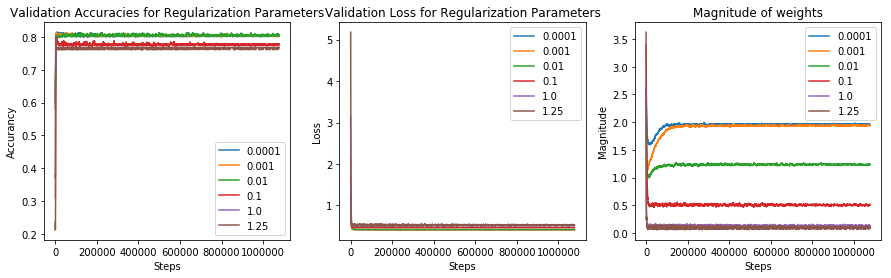

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))


for l, valid_acc in zip(l_coeff, valid_acc_list):
    axs[0].plot(step_list, valid_acc, label = l)
#     axs[0].set_xlim(0, 200000)
axs[0].set_title('Validation Accuracies for Regularization Parameters')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Accurancy')
axs[0].legend()

for l, valid_loss in zip(l_coeff, valid_loss_list):
    axs[1].plot(step_list, valid_loss, label = l)
#     axs[1].set_xlim(0, 200000)
axs[1].set_title('Validation Loss for Regularization Parameters')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Loss')
axs[1].legend()

for l, norm_a in zip(l_coeff, norm_a_list):
    axs[2].plot(step_list, norm_a, label = l)
#     axs[2].set_xlim(0, 200000)
axs[2].set_title('Magnitude of weights')
axs[2].set_xlabel('Steps')
axs[2].set_ylabel('Magnitude')
axs[2].legend()


plt.show()

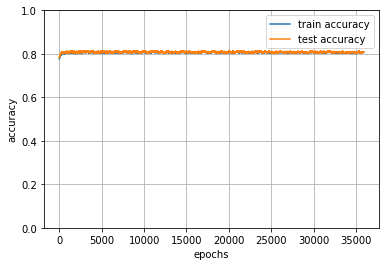

In [25]:
fig, ax = plt.subplots()
ax.plot(acc_train, label='train accuracy')
ax.plot(acc_test, label='test accuracy')
ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.grid()

plt.show();